# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pysra

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams['figure.dpi'] = 120

## Create a point source theory RVT motion

In [3]:
motions = [
    pysra.motion.SourceTheoryRvtMotion(5.0, 30, 'wna'),
    pysra.motion.SourceTheoryRvtMotion(6.0, 30, 'wna'),
    pysra.motion.SourceTheoryRvtMotion(7.0, 30, 'wna'),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pysra.site.Profile([
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=100), 10, 400),
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=200), 10, 450),
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=400), 30, 600),
    pysra.site.Layer(
        pysra.site.SoilType('Rock', 24., None, 0.01), 0, 1200),
])

## Create the site response calculator

In [5]:
calc = pysra.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pysra.variation.ToroThicknessVariation()
var_velocity = pysra.variation.DepthDependToroVelVariation.generic_model(
    'USGS C')
var_soiltypes = pysra.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pysra.output.OutputCollection([
    pysra.output.ResponseSpectrumOutput(
        # Frequency
        freqs,
        # Location of the output
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
    pysra.output.ResponseSpectrumRatioOutput(
        # Frequency
        freqs,
        # Location in (denominator),
        pysra.output.OutputLocation('outcrop', index=-1),
        # Location out (numerator)
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
    pysra.output.InitialVelProfile(),
])

## Perform the calculation

In [8]:
count = 20
outputs.reset()
for i, p in enumerate(pysra.variation.iter_varied_profiles(
    profile,
    count,
    #var_thickness=var_thickness,
    var_velocity=var_velocity,
    #var_soiltypes=var_soiltypes
)):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f'p{i}', f'm{j}')
        calc(m, p, p.location('outcrop', index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

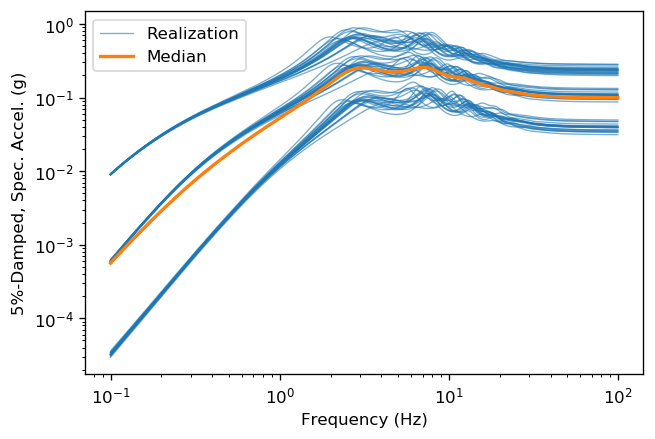

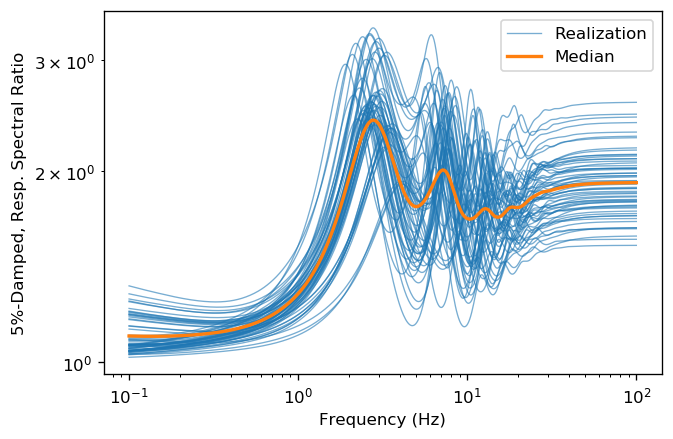

In [9]:
for o in outputs[:-1]:
    ax = o.plot(style='stats')

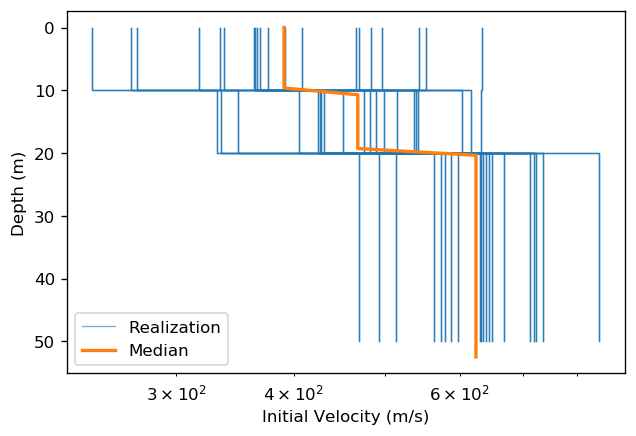

In [10]:
ax = outputs[-1].plot(style='stats')

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [11]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.200819  1.067810  1.042302  1.244900  1.083307  1.053490   
0.101394    1.200139  1.067761  1.042630  1.244052  1.083234  1.053893   
0.102807    1.199462  1.067717  1.042963  1.243207  1.083167  1.054300   
0.104240    1.198788  1.067677  1.043298  1.242365  1.083105  1.054712   
0.105693    1.198116  1.067644  1.043637  1.241526  1.083049  1.055127   
...              ...       ...       ...       ...       ...       ...   
94.613238   2.076292  1.968176  1.844746  2.260138  2.127689  1.959917   
95.932095   2.076350  1.968230  1.844822  2.260233  2.127782  1.960040   
97.269336   2.076406  1.968283  1.844897  2.260325  2.127872  1.960159   
98.625218   2.076461  1.968335  1.844969  2.260414  2.127960  1.960274   
100.000000  2.076513  1.968384  1.845039  2.260500  2.128045  1.960386   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.169775  1.057316  1.035316  1.203282  ...  1.029567  1.281164   
0.101394    1.169216  1.057280  1.035595  1.202538  ...  1.029804  1.280158   
0.102807    1.168660  1.057249  1.035877  1.201797  ...  1.030044  1.279155   
0.104240    1.168105  1.057223  1.036161  1.201059  ...  1.030287  1.278155   
0.105693    1.167553  1.057202  1.036449  1.200323  ...  1.030532  1.277159   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   1.828160  1.757208  1.666484  1.764133  ...  1.859552  2.436461   
95.932095   1.828213  1.757255  1.666546  1.764192  ...  1.859587  2.436574   
97.269336   1.828266  1.757301  1.666606  1.764250  ...  1.859621  2.436684   
98.625218   1.828316  1.757346  1.666664  1.764306  ...  1.859654  2.436790   
100.000000  1.828365  1.757389  1.666721  1.764360  ...  1.859686  2.436894   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.095384  1.062022  1.188667  1.063626  1.039512  1.197666   
0.101394    1.095291  1.062480  1.188029  1.063582  1.039821  1.196974   
0.102807    1.095204  1.062942  1.187394  1.063542  1.040133  1.196284   
0.104240    1.095122  1.063409  1.186761  1.063508  1.040448  1.195598   
0.105693    1.095047  1.063880  1.186130  1.063479  1.040766  1.194914   
...              ...       ...       ...       ...       ...       ...   
94.613238   2.272362  2.062118  1.880445  1.805605  1.703167  1.788905   
95.932095   2.272478  2.062267  1.880511  1.805665  1.703244  1.788986   
97.269336   2.272591  2.062412  1.880576  1.805724  1.703319  1.789065   
98.625218   2.272700  2.062552  1.880638  1.805781  1.703391  1.789141   
100.000000  2.272806  2.062688  1.880698  1.805836  1.703462  1.789215   

                                
                  m1        m2  
0.100000    1.066354  1.041260  
0.101394    1.066305  1.041581  
0.102807    1.066260  1.041905  
0.104240    1.066221  1.042233  
0.105693    1.066187  1.042564  
...              ...       ...  
94.613238   1.730617  1.629071  
95.932095   1.730694  1.629162  
97.269336   1.730768  1.629251  
98.625218   1.730839  1.629337  
100.000000  1.730909  1.629421  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [12]:
# Add names for clarity
df.columns.names = ('profile', 'motion')
df.index.name = 'freq'
# Transform into a long format
df = df.reset_index().melt(id_vars='freq')
df

,freq,profile,motion,value
0,0.100000,p0,m0,1.200819
1,0.101394,p0,m0,1.200139
2,0.102807,p0,m0,1.199462
3,0.104240,p0,m0,1.198788
4,0.105693,p0,m0,1.198116
...,...,...,...,...
29995,94.613238,p19,m2,1.629071
29996,95.932095,p19,m2,1.629162
29997,97.269336,p19,m2,1.629251
29998,98.625218,p19,m2,1.629337


In [13]:
def calc_stats(group):
    ln_value = np.log(group['value'])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({'median': median, 'ln_std': ln_std})

stats = df.groupby(['freq', 'motion']).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.195179  0.044455
           m1      1.066286  0.016478
           m2      1.041791  0.011318
0.101394   m0      1.194530  0.044284
           m1      1.066237  0.016454
...                     ...       ...
98.625218  m1      1.927290  0.106502
           m2      1.809122  0.094490
100.000000 m0      2.029077  0.117168
           m1      1.927344  0.106507
           m2      1.809196  0.094497

[1500 rows x 2 columns]

In [14]:
stats = stats\
    .reset_index('motion')\
    .pivot(columns='motion')\
    .swaplevel(0, 1, axis=1)\
    .sort_index(axis=1)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.044455  1.195179  0.016478  1.066286  0.011318  1.041791
0.101394    0.044284  1.194530  0.016454  1.066237  0.011393  1.042113
0.102807    0.044113  1.193882  0.016431  1.066193  0.011469  1.042439
0.104240    0.043942  1.193236  0.016409  1.066154  0.011546  1.042767
0.105693    0.043772  1.192594  0.016388  1.066121  0.011623  1.043099
...              ...       ...       ...       ...       ...       ...
94.613238   0.117154  2.028836  0.106484  1.927119  0.094466  1.808888
95.932095   0.117158  2.028899  0.106490  1.927178  0.094474  1.808968
97.269336   0.117161  2.028960  0.106496  1.927235  0.094482  1.809047
98.625218   0.117165  2.029019  0.106502  1.927290  0.094490  1.809122
100.000000  0.117168  2.029077  0.106507  1.927344  0.094497  1.809196

[500 rows x 6 columns]

Access the properties of each motion like:

In [15]:
stats['m0']

,ln_std,median
freq,,
0.100000,0.044455,1.195179
0.101394,0.044284,1.194530
0.102807,0.044113,1.193882
0.104240,0.043942,1.193236
0.105693,0.043772,1.192594
...,...,...
94.613238,0.117154,2.028836
95.932095,0.117158,2.028899
97.269336,0.117161,2.028960


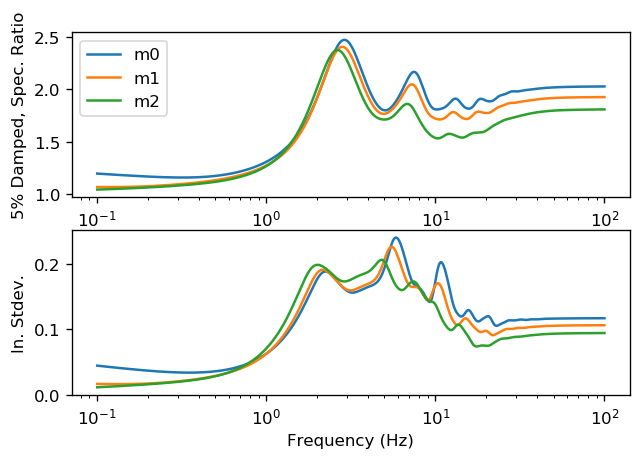

In [16]:
fig, axes = plt.subplots(nrows=2, subplot_kw={'xscale': 'log'})

for name, g in stats.groupby(level=0, axis=1):
    for ax, key in zip(axes, ['median', 'ln_std']):
        ax.plot(g.index, g[(name, key)], label=name)
        

axes[0].set(ylabel='5% Damped, Spec. Ratio')
axes[0].legend()

axes[1].set(ylabel='ln. Stdev.', xlabel='Frequency (Hz)')

fig;